<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>

# Vector Representations
## *Data Science Unit 4 Sprint 2 Assignment 2*

In [36]:
import re
import string
from collections import Counter
import squarify

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import spacy
from spacy.tokenizer import Tokenizer

from bs4 import BeautifulSoup
import html as ihtml

## 1) *Clean:* Job Listings from indeed.com that contain the title "Data Scientist" 

You have `job_listings.csv` in the data folder for this module. The text data in the description column is still messy - full of html tags. Use the [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) library to clean up this column. You will need to read through the documentation to accomplish this task. 

In [49]:
from bs4 import BeautifulSoup
import requests

df = pd.read_csv("https://raw.githubusercontent.com/cardstud/DS-Unit-4-Sprint-1-NLP/master/module2-vector-representations/data/job_listings.csv", index_col=0)
df.head()              

,description,title
0,"b""<div><div>Job Requirements:</div><ul><li><p>...",Data scientist
1,b'<div>Job Description<br/>\n<br/>\n<p>As a Da...,Data Scientist I
2,b'<div><p>As a Data Scientist you will be work...,Data Scientist - Entry Level
3,"b'<div class=""jobsearch-JobMetadataHeader icl-...",Data Scientist
4,b'<ul><li>Location: USA \xe2\x80\x93 multiple ...,Data Scientist


In [50]:
# clean_text function

def clean_text(text):
    text = BeautifulSoup(text, "html.parser").get_text() # removes html using the beautiful soup library
    text = text[1:] # removes first b character
    text = text.replace('\\n', ' ') #replaces newline with spaces
    text = text.replace('/', ' ') #replaces backslashes with spaces
    text = text.lower() #makes all text lower case
    text = re.sub(r'[^a-zA-Z ^0-9]', '', text) # leaves just letters/numbers
    text = re.sub(r'(x.[0-9])', '', text) #takes out special characters
    return text

# clean the descriptions
for i in range(0, len(df)):
    df['description'][i] = clean_text(df['description'][i])
       
df['description'][6] 

'as spotify premium swells to over 96m subscribers around the globe we are looking for new ways to continue to grow our subscription business you would be joining spotify on the premium analytics team a core business strategy and insights team as an associate data scientist in this unique position your work would be essential in shaping how spotify is able to grow through datadriven recommendations new product offerings and innovative marketing efforts you will see first hand how your work translates into new strategies products and consumer experiences as we enter a new phase in spotify premiums life  you will work with a global team of worldclass analysts data scientists business managers marketers and engineers we are all passionate about what we do and move forward with high impact projects at a high pace learning and improving is part of our daily routine and you will be free to develop your own skills and ways of working at your fingertips youll have access to petabytes of data a

In [51]:
df.head()

,description,title
0,job requirements conceptual understanding in m...,Data scientist
1,job description as a data scientist 1 you wil...,Data Scientist I
2,as a data scientist you will be working on con...,Data Scientist - Entry Level
3,4969 6756 a monthcontractunder the general su...,Data Scientist
4,location usa multiple locations 2 years of an...,Data Scientist


## 2) Use Spacy to tokenize the listings 

In [52]:
nlp = spacy.load("en_core_web_lg")
tokenizer = Tokenizer(nlp.vocab)

In [53]:
# Stop words
STOP_WORDS = nlp.Defaults.stop_words.union(['job', 'apply', 'new', 'company', 'opportunity', 'internship', 'work', 'working', 'ability',
                                            'understand', 'successful', 'display', 'must'])

In [54]:
# pipeline - lemmatize and remove any stopwords or spaces
tokens = []

for doc in tokenizer.pipe(df['description']):
    doc_tokens = []
    for token in doc:
        if (token.lemma_ not in STOP_WORDS) & (token.text != ' '):
            doc_tokens.append(token.lemma_)
    tokens.append(doc_tokens)

In [55]:
df['tokens'] = tokens
df['tokens'].head()

0    [requirement, conceptual, machine, learn, mode...
1    [description, datum, scientist, 1, help, build...
2    [datum, scientist, consult, business, responsi...
3    [4969, 6756, monthcontractunder, general, supe...
4    [location, usa, multiple, location, 2, year, a...
Name: tokens, dtype: object

In [56]:
# count function
def count(docs):

        word_counts = Counter()
        appears_in = Counter()
        
        total_docs = len(docs)

        for doc in docs:
            word_counts.update(doc)
            appears_in.update(set(doc))

        temp = zip(word_counts.keys(), word_counts.values())
        
        wc = pd.DataFrame(temp, columns = ['word', 'count'])

        wc['rank'] = wc['count'].rank(method='first', ascending=False)
        total = wc['count'].sum()

        wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
        wc = wc.sort_values(by='rank')
        wc['cul_pct_total'] = wc['pct_total'].cumsum()

        t2 = zip(appears_in.keys(), appears_in.values())
        ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
        wc = ac.merge(wc, on='word')

        wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
        return wc.sort_values(by='rank')

In [57]:
wc = count(df['tokens'])
wc.head()

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
57,datum,422,4292,1.0,0.033801,0.033801,0.990610
30,experience,410,1999,2.0,0.015743,0.049544,0.962441
285,team,370,1363,3.0,0.010734,0.060279,0.868545
92,business,324,1251,4.0,0.009852,0.070131,0.760563
32,model,330,1248,5.0,0.009829,0.079959,0.774648


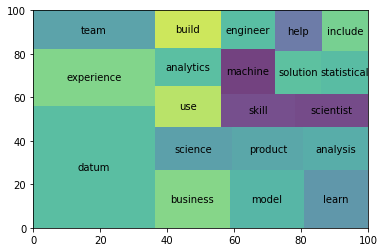

In [58]:
# graph 
wc_top25 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top25['pct_total'], label=wc_top25['word'], alpha=.75)
plt.show()

## 3) Use Scikit-Learn's CountVectorizer to get word counts for each listing.

In [59]:
def tokenize(document):
    doc = nlp(document)
    return [token.lemma_.strip() for token in doc if (token.is_stop != True) and (token.is_punct != True) and (token.text != ' ')]

In [60]:
# Count vectorizer
from sklearn.feature_extraction.text import CountVectorizer

# transform
vect = CountVectorizer(tokenizer=tokenize, stop_words=STOP_WORDS)

# build vocab
vect.fit(df['description'])

# transform text
dtm = vect.transform(df['description'])
print(dtm.shape)

C:\Users\Todd\anaconda3\envs\U4-S1-NLP\lib\site-packages\sklearn\feature_extraction\text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"
C:\Users\Todd\anaconda3\envs\U4-S1-NLP\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['d', 'm', 've'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


(426, 7690)


In [61]:
dtmwc = pd.DataFrame(dtm.todense(), columns=vect.get_feature_names())
dtmwc.head()

,,-PRON-,0,00,02,02115,03,030,030547069,04,...,zfs,zheng,zillow,zillows,zogsports,zone,zoom,zuckerberg,zurich,zurichs
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 4) Visualize the most common word counts

In [62]:
sums = dtm.sum(axis=0)
word_freq = [(word, sums[0, idx]) for word, idx in vect.vocabulary_.items()]
word_freq = sorted(word_freq, key = lambda x: x[1], reverse = True)
word_freq[:25]

[('datum', 2979),
 ('experience', 1935),
 ('team', 1361),
 ('data', 1313),
 ('business', 1251),
 ('science', 970),
 ('model', 915),
 ('product', 891),
 ('analysis', 809),
 ('analytic', 786),
 ('skill', 718),
 ('scientist', 706),
 ('machine', 703),
 ('build', 643),
 ('develop', 622),
 ('learn', 576),
 ('statistical', 576),
 ('solution', 569),
 ('help', 558),
 ('include', 555),
 ('customer', 551),
 ('problem', 527),
 ('technology', 519),
 ('year', 512),
 ('learning', 498)]

In [63]:
df_top25 = pd.DataFrame(word_freq[:25])
df_top25.head(25)

,0,1
0,datum,2979
1,experience,1935
2,team,1361
3,data,1313
4,business,1251
5,science,970
6,model,915
7,product,891
8,analysis,809
9,analytic,786


## 5) Use Scikit-Learn's tfidfVectorizer to get a TF-IDF feature matrix

In [64]:
# Tunning Parameters

# Instantiate vectorizer object
tfidf = TfidfVectorizer(stop_words='english', 
                        ngram_range=(1,2),
                        max_df=.97, # percentage if appears in about 97% of documents
                        min_df=5, # at least in 5 documents
                       # max_features= looks at all words and takes top 5000 in documents
                        tokenizer=tokenize)

# tokenize and fit
tfidf.fit(df['description'])

# transform
dtm = tfidf.transform(df['description']) 

# Get feature names to use as df col headers
dtm = pd.DataFrame(dtm.todense(), columns=tfidf.get_feature_names())

# View Feature Matrix as DataFrame
dtm.head()

C:\Users\Todd\anaconda3\envs\U4-S1-NLP\lib\site-packages\sklearn\feature_extraction\text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


,,ability,datum,deep,develop,disability,experience,gender,look,math,...,year handson,year industry,year professional,year related,year relevant,year work,yes,york,york city,york office
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 6) Create a NearestNeighbor Model. Write the description of your ideal datascience job and query your job listings. 

In [65]:
from sklearn.neighbors import NearestNeighbors

# Fit on DTM
nn = NearestNeighbors(n_neighbors=5, algorithm='kd_tree')
nn.fit(dtm)

NearestNeighbors(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [66]:
ideal = ["""The job includes machine learning, AI, python to gather info on aerospace or defense sector"""]

In [67]:
new = tfidf.transform(ideal)
nn.kneighbors(new.todense())

(array([[1.31437572, 1.31527948, 1.33384259, 1.33407883, 1.33415398]]),
 array([[151,  91, 143, 396, 311]], dtype=int64))

In [68]:
df['description'][151]

'the data scientist is a critical position within dss and in the data organization who specializes in applying machine learning methods to meet optimization personalization recommendations and efficiency related challenges in close collaboration with engineering and business partners in this role you will build and apply machine learning techniques and modern statistics to data both augment decisionmaking but to also significantly improve operational process problems through automation you will collaborate across teams to define problems and develop automated solutions with the data product and engineering teams to be built into our products  responsibilities  reframe objectives as machine learning tasks that can deliver actionable insights accurate predictions and effective optimization implement and execute machine learning with reliability and reproducibility explain how models and systems work to both nontechnical and technical stakeholders collaborate with engineering teams to bui

In [69]:
df['description'][91]

'atos se societas europaea is a leader in digital services with pro forma annual revenue of circa xac 12 billion and circa 100000 employees in 72 countries serving a global client base the group provides consulting  systems integration services managed services  bpo cloud operations big data  cybersecurity solutions as well as transactional services through worldline the european leader in the payments and transactional services industry with its deep technology expertise and industry knowledge the group works with clients across different business sectors defense financial services health manufacturing media utilities public sector retail telecommunications and transportation atos is focused on business technology that powers progress and helps organizations to create their firm of the future the group is the worldwide information technology partner for the olympic  paralympic games and is listed on the euronext paris market atos operates under the brands atos atos consulting atos wor

In [70]:
df['description'][143]

'date mar 19 2019 ericsson overview  ericsson is worlds leading provider of communications technology and services our offerings include services consulting software and infrastructure within information and communications technology using innovation to empower people business and society ericsson is working towards the networked society a world connected in real time that will open up opportunities to create freedom transform society and drive solutions to some of our planets greatest challenges  we are truly a global company operating across borders in over 180 countries offering a diverse performancedriven culture and an innovative and engaging environment as an ericsson employee you will have freedom to think big and the support to turn ideas into achievements continuous learning and growth opportunities allow you to acquire the knowledge and skills necessary to progress and reach your career goals we invite you to join our team  our exciting opportunity it will be practically impo

## Stretch Goals

 - Try different visualizations for words and frequencies - what story do you want to tell with the data?
 - Scrape Job Listings for the job title "Data Analyst". How do these differ from Data Scientist Job Listings
 - Try and identify requirements for experience specific technologies that are asked for in the job listings. How are those distributed among the job listings?
 - Use a clustering algorithm to cluster documents by their most important terms. Do the clusters reveal any common themes?
  - **Hint:** K-means might not be the best algorithm for this. Do a little bit of research to see what might be good for this. Also, remember that algorithms that depend on Euclidean distance break down with high dimensional data.
 - Create a labeled dataset - which jobs will you apply for? Train a model to select the jobs you are most likely to apply for. :) 